In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import os
import pickle
from dateutil.parser import parse
import datetime
from dateutil.parser import parse
import math
from numpy import mean

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline as SKLpipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.tree import export_text
import dtreeviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
import umap

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IMBLpipeline

from sklearn.inspection import permutation_importance
import shap
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import warnings

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import ipynbname
notebook_name = ipynbname.name()

import seaborn as sns

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 35)

2024-04-05 14:33:55.837339: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define directory path name and timestamp

# Get the current date and time as a string
timestamp = datetime.datetime.now().strftime('%d%m%Y_%H%M')

# Construct the directory path with the models folder and timestamp
dir_path = f"models/{timestamp}"
    
# Create the directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [3]:
import random
# Generate a random number between 0 and 100
# rand_num = random.randint(0, 10000)
rand_num = 9880

#save random state number
with open(f"{dir_path}/random_state_number-{notebook_name}-{timestamp}.txt", 'w') as f:
    f.write(str(rand_num))
print(rand_num)

9880


In [4]:
# read df pickle
df_alg = pd.read_pickle("objects/df_alg-HAB_preprocessing_5_1")
# data = pd.read_pickle("data/preprocessed/hab_org-data-HAB_part2-preprocessing-5_2")
data = pd.read_pickle("data/preprocessed/hab_interp_data-HAB_part2-preprocessing-5_2")

data.drop(columns=["sampling station", "date"], inplace=True)
# data.set_index('date', inplace=True)


# slice by station and time
# data = data[data["sampling station"] == "Debeli_rtic"].loc["2008-01-01" : "2021-12-31"]

data.isnull().sum()

DSP                        1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
Chl-a                    422
salinity                  21
T                         59
SECCHI                   450
DIN                      352
PO4-P                    349
Soca                       0
month                      0
lipophylic_toxins        320
dtype: int64

In [5]:
# Class distribution
data["lipophylic_toxins"].value_counts(dropna=False)

neg    996
NaN    320
poz    136
Name: lipophylic_toxins, dtype: int64

In [6]:
# move month to first place
cols = data.columns.tolist()  # Get a list of column names
cols = [cols[-2]] + cols[:-2] + [cols[-1]]  # Move the one before the last column to the first position
data = data[cols]

In [7]:
data.drop(columns=["Chl-a","PO4-P","DIN","SECCHI"], inplace=True)
# data.drop(columns=["SECCHI"], inplace=True)
data.isnull().sum()

month                      0
DSP                        1
Dinophysis caudata         1
Dinophysis fortii          1
Phalacroma rotundatum      1
Dinophysis sacculus        1
Dinophysis tripos          1
sun [h]                    0
air temp                   0
wind strength              0
precipitation              0
salinity                  21
T                         59
Soca                       0
lipophylic_toxins        320
dtype: int64

# Descriptive analysis

In [8]:
# describe
description = data.describe(include='all').round(0)
description = description.drop(['unique', 'top', 'freq'])

# Replace NaN values with "-" in the description
description = description.fillna("-")

# Convert numeric columns to integers
for col in description.select_dtypes(include=['float64']).columns:
    description[col] = description[col].astype(int)


# Calculate the number of missing values for each column
missing_values = data.isna().sum()
missing_values.name = 'missing_values'

# Append the missing_values row to the description DataFrame
description_with_missing = description.append(missing_values)
# description_with_missing = description_with_missing.drop(['unique', 'top', 'freq'])

# Transpose the DataFrame
transposed_description = description_with_missing.T
transposed_description


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


count  mean   std  min   25%   50%   75%    max  \
month                  1452     7     3    1     5     8    10     12   
DSP                    1451   106   340    0    10    37    90   7630   
Dinophysis caudata     1451    25    88    0     0     0    13   1309   
Dinophysis fortii      1451    26   160    0     0     0    10   4624   
Phalacroma rotundatum  1451    14    30    0     0    10    20    393   
Dinophysis sacculus    1451    29   178    0     0     0    10   4639   
Dinophysis tripos      1451     5    41    0     0     0     0   1139   
sun [h]                1452   159    61   23   113   161   207    278   
air temp               1452    17     6   -1    12    17    22     27   
wind strength          1452     3     0    1     3     3     3      5   
precipitation          1452    58    51    0    20    45    79    268   
salinity               1431    37    26   24    36    37    37    999   
T                      1393    19     5    6    16    20    24     28   
Soca                   1452  3295  2330  594  1636  2581  4237  16040   
lipophylic_toxins      1132     -     -    -     -     -     -      -   

                      missing_values  
month                              0  
DSP                                1  
Dinophysis caudata                 1  
Dinophysis fortii                  1  
Phalacroma rotundatum              1  
Dinophysis sacculus                1  
Dinophysis tripos                  1  
sun [h]                            0  
air temp                           0  
wind strength                      0  
precipitation                      0  
salinity                          21  
T                                 59  
Soca                               0  
lipophylic_toxins                320

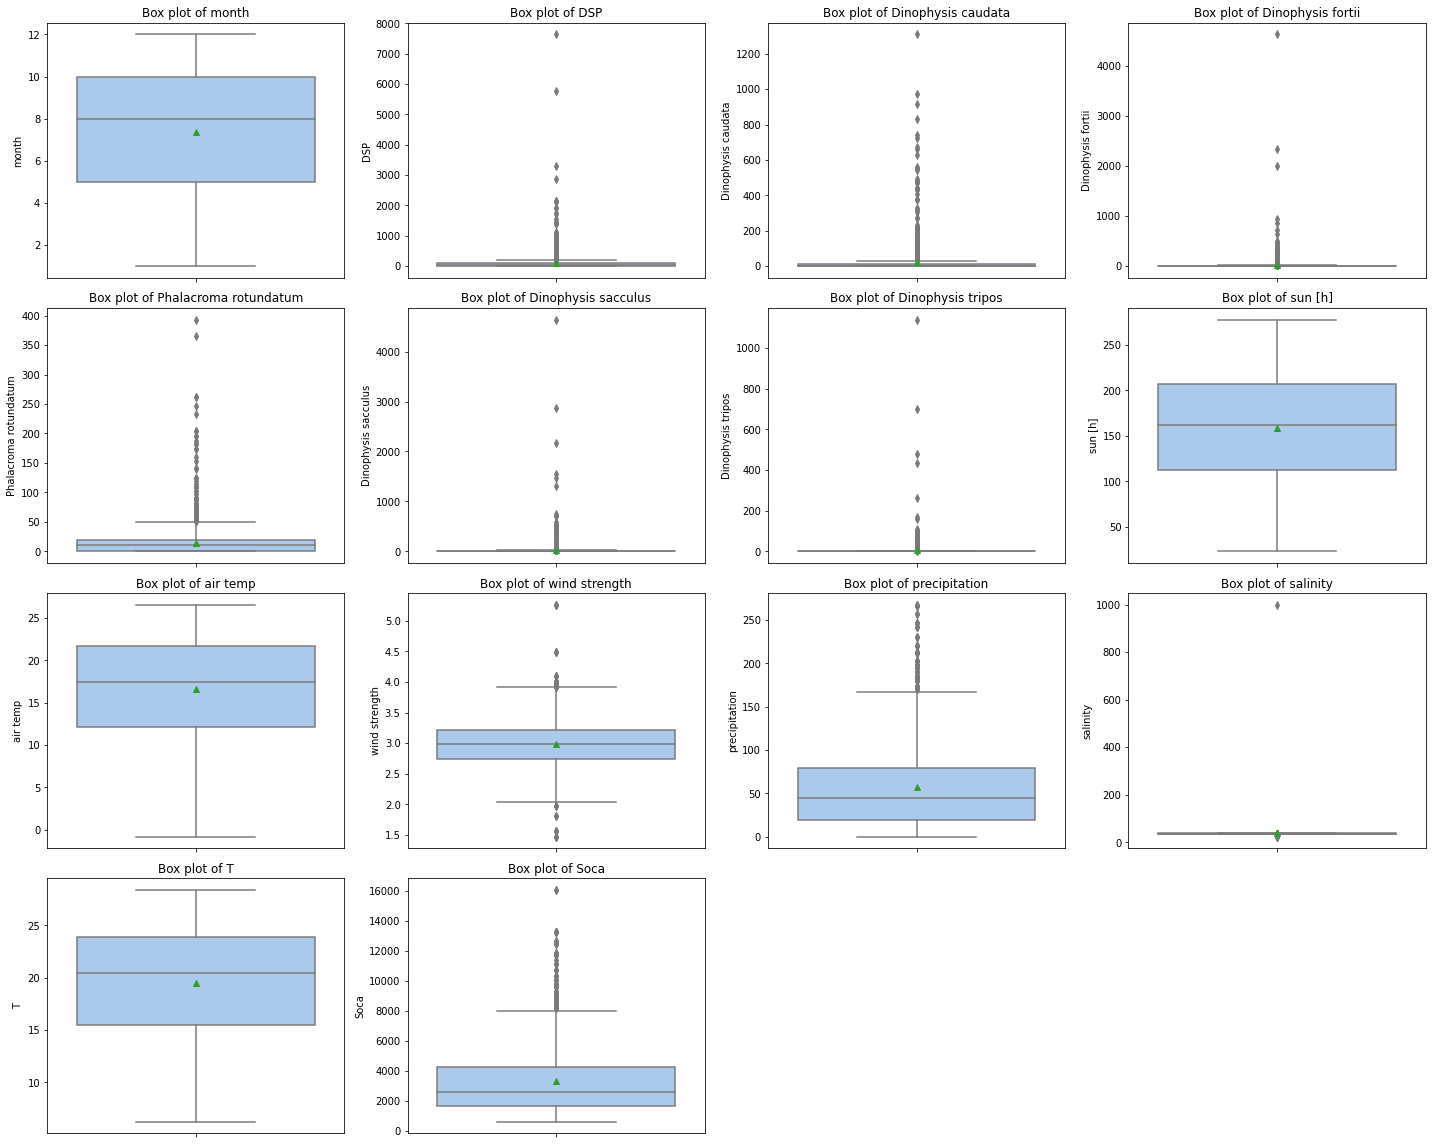

In [9]:
# Visualize the distribution of each variable with boxplot
num_columns = len(data.columns)
subplots_per_row = 4
num_rows = math.ceil(num_columns / subplots_per_row)

fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(20, num_rows * 4))

for i, column in enumerate(data.columns):
    row = i // subplots_per_row
    col = i % subplots_per_row
    
    if data[column].dtype == 'float64' or data[column].dtype == 'int64':
        sns.boxplot(data=data, y=column, ax=axes[row, col], palette="pastel", showmeans=True)
        axes[row, col].set_title(f'Box plot of {column}')
    else:
        # Skip categorical columns for box plots
        axes[row, col].set_visible(False)

# Hide unused subplots
for i in range(num_columns, num_rows * subplots_per_row):
    row = i // subplots_per_row
    col = i % subplots_per_row
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.savefig(f"{dir_path}/feature_distribution_boxplots-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()


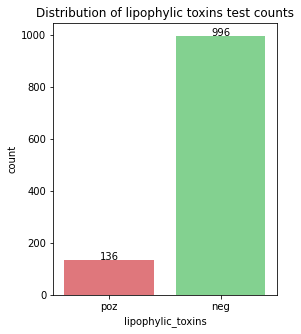

In [10]:
# Create a figure with a more narrow width
fig, ax = plt.subplots(figsize=(4, 5))

# Create a custom  pastel color palette
custom_pastel = sns.color_palette("bright")

# Set the color for class 1 to orange
custom_pastel[1] = sns.color_palette("bright")[2]
custom_pastel[0] = sns.color_palette("bright")[3]


# Create a count plot
sns.countplot(data=data, x="lipophylic_toxins", ax=ax, palette=custom_pastel, alpha=0.6)
ax.set_title('Distribution of lipophylic toxins test counts')

# Add numbers on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5,
            p.get_height(), ha='center', fontsize=10)

# Show the plot
plt.savefig(f"{dir_path}/lipophylic_toxins_test_counts-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

## Descriptive analysis by month

In [11]:
# table of mean values for each feature by month 
import calendar

grouped_means = data.groupby('month').mean()

# Count binary values for the categorical feature grouped by month
binary_counts = data.groupby('month')['lipophylic_toxins'].value_counts().unstack()

# Calculate the ratio of positive values for each month
sum_positive = binary_counts["poz"].sum()
positive_ratios = [i for i in (binary_counts["poz"] / sum_positive)] 
positive_ratios = [round(v * 100, 1) for v in positive_ratios]

# Change month names
month_names = {i: calendar.month_name[i] for i in range(1, 13)}

# Update the index using the month_names dictionary
grouped_means.index = grouped_means.index.map(month_names)
binary_counts.index = binary_counts.index.map(month_names)

# Concatenate the grouped_means and binary_counts DataFrames
result = pd.concat([grouped_means, binary_counts], axis=1).round(2)

# Add the positive_ratios Series as a new column to the result DataFrame
result["poz %"] = positive_ratios
result.to_csv(f"{dir_path}/features_by_month_A-{notebook_name}-{timestamp}.csv", index=True)

result

DSP  Dinophysis caudata  Dinophysis fortii  \
month                                                      
January      9.00                1.16               2.96   
February    12.86                1.02               4.08   
March       12.38                0.21               0.68   
April       15.49                0.97               0.48   
May         59.00                6.00               0.97   
June       146.89               29.23               1.49   
July       237.04               67.07              44.50   
August     129.67               55.46              24.23   
September  116.79               28.04              58.58   
October     97.76               13.21              35.56   
November    80.54               13.81              29.33   
December    81.96                2.33              51.95   

           Phalacroma rotundatum  Dinophysis sacculus  Dinophysis tripos  \
month                                                                      
January                     3.66                 0.09               0.20   
February                    3.38                 0.20               0.69   
March                       3.79                 0.43               0.64   
April                       5.24                 4.51               0.00   
May                         9.67                34.25               0.15   
June                       12.87                93.28               0.09   
July                       19.57                97.25               0.04   
August                     19.01                22.96               0.08   
September                  12.81                 3.57               6.04   
October                    19.39                 2.17              19.76   
November                   19.09                 1.11               8.90   
December                   16.06                 1.18               4.77   

           sun [h]  air temp  wind strength  precipitation  salinity      T  \
month                                                                         
January      72.62      4.95           2.71          46.53     36.95  11.07   
February     80.19      5.52           3.06          60.66     37.02  10.22   
March       118.56      7.55           3.30          30.01     37.17   9.49   
April       144.63     11.69           3.17          54.90     36.93  11.68   
May         171.96     16.22           2.89          48.55     36.57  14.87   
June        202.85     20.51           2.83          45.16     35.60  20.28   
July        227.47     23.31           2.88          38.27     35.40  23.48   
August      220.46     23.46           3.03          54.38     41.92  24.93   
September   174.65     20.06           3.11          69.73     36.59  24.38   
October     127.60     15.56           3.08          72.07     36.91  21.70   
November     82.48     11.35           3.01          74.21     36.72  17.61   
December     65.97      7.51           2.83          81.32     36.81  15.56   

              Soca  neg  poz  poz %  
month                                
January    4652.16   15    3    2.2  
February   4378.79   21    3    2.2  
March      3257.07   28    2    1.5  
April      3826.10   66    2    1.5  
May        3864.97   89   14   10.3  
June       3436.93  115   12    8.8  
July       2473.18  125   18   13.2  
August     1637.28  126   11    8.1  
September  2102.01  143   31   22.8  
October    2988.28  138   24   17.6  
November   5263.97   91   13    9.6  
December   5868.74   39    3    2.2

In [12]:
# table of mean values for each feature by month
import calendar

grouped_means = data.groupby('month').mean()

# Count binary values for the categorical feature grouped by month
binary_counts = data.groupby('month')['lipophylic_toxins'].value_counts().unstack()

# Calculate the ratio of positive values for each month
sum_positive = binary_counts["poz"].sum()
positive_ratios = [i for i in (binary_counts["poz"] / sum_positive)] 
positive_ratios = [round(v * 100, 1) for v in positive_ratios]

# Calculate the ratio of negative values for each month
sum_negative = binary_counts["neg"].sum()
negative_ratios = [i for i in (binary_counts["neg"] / sum_negative)]
negative_ratios = [round(v * 100, 1) for v in negative_ratios]

# Change month names
month_names = {i: calendar.month_name[i] for i in range(1, 13)}

# Update the index using the month_names dictionary
grouped_means.index = grouped_means.index.map(month_names)
binary_counts.index = binary_counts.index.map(month_names)

# Concatenate the grouped_means and binary_counts DataFrames
result = pd.concat([grouped_means, binary_counts], axis=1).round(2)

# Drop the 'neg' and 'poz' columns
result = result.drop(columns=['neg', 'poz'])

# Add the positive_ratios and negative_ratios Series as new columns to the result DataFrame
result["poz %"] = positive_ratios
result["neg %"] = negative_ratios

result.to_csv(f"{dir_path}/features_by_month_B-{notebook_name}-{timestamp}.csv", index=True)
result

DSP  Dinophysis caudata  Dinophysis fortii  \
month                                                      
January      9.00                1.16               2.96   
February    12.86                1.02               4.08   
March       12.38                0.21               0.68   
April       15.49                0.97               0.48   
May         59.00                6.00               0.97   
June       146.89               29.23               1.49   
July       237.04               67.07              44.50   
August     129.67               55.46              24.23   
September  116.79               28.04              58.58   
October     97.76               13.21              35.56   
November    80.54               13.81              29.33   
December    81.96                2.33              51.95   

           Phalacroma rotundatum  Dinophysis sacculus  Dinophysis tripos  \
month                                                                      
January                     3.66                 0.09               0.20   
February                    3.38                 0.20               0.69   
March                       3.79                 0.43               0.64   
April                       5.24                 4.51               0.00   
May                         9.67                34.25               0.15   
June                       12.87                93.28               0.09   
July                       19.57                97.25               0.04   
August                     19.01                22.96               0.08   
September                  12.81                 3.57               6.04   
October                    19.39                 2.17              19.76   
November                   19.09                 1.11               8.90   
December                   16.06                 1.18               4.77   

           sun [h]  air temp  wind strength  precipitation  salinity      T  \
month                                                                         
January      72.62      4.95           2.71          46.53     36.95  11.07   
February     80.19      5.52           3.06          60.66     37.02  10.22   
March       118.56      7.55           3.30          30.01     37.17   9.49   
April       144.63     11.69           3.17          54.90     36.93  11.68   
May         171.96     16.22           2.89          48.55     36.57  14.87   
June        202.85     20.51           2.83          45.16     35.60  20.28   
July        227.47     23.31           2.88          38.27     35.40  23.48   
August      220.46     23.46           3.03          54.38     41.92  24.93   
September   174.65     20.06           3.11          69.73     36.59  24.38   
October     127.60     15.56           3.08          72.07     36.91  21.70   
November     82.48     11.35           3.01          74.21     36.72  17.61   
December     65.97      7.51           2.83          81.32     36.81  15.56   

              Soca  poz %  neg %  
month                             
January    4652.16    2.2    1.5  
February   4378.79    2.2    2.1  
March      3257.07    1.5    2.8  
April      3826.10    1.5    6.6  
May        3864.97   10.3    8.9  
June       3436.93    8.8   11.5  
July       2473.18   13.2   12.6  
August     1637.28    8.1   12.7  
September  2102.01   22.8   14.4  
October    2988.28   17.6   13.9  
November   5263.97    9.6    9.1  
December   5868.74    2.2    3.9

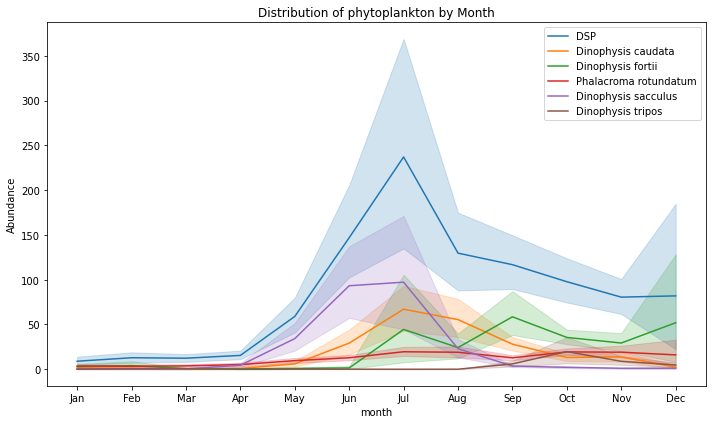

In [13]:
# Plot phytoplantkon distribution by month
# Get the phytoplankton columns
phytoplankton = data.iloc[:, 1:7].columns

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distribution of each of the first 6 numerical variables by month on the same plot
for column in phytoplankton:
    sns.lineplot(data=data, x='month', y=column, ax=ax, label=column, palette="pastel")

# Customize the plot
ax.set_title('Distribution of phytoplankton by Month')
ax.set_ylabel('Abundance')  # Set the y-axis label to "Abundance"
ax.legend()

# Customize the x-axis ticks and labels to show only month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)

# Save and show the plot
plt.tight_layout()
plt.savefig(f"{dir_path}/phytoplankton_abundance_distribution_by_month-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

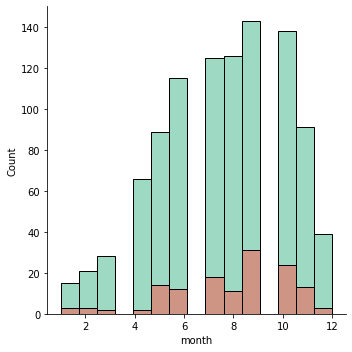

In [14]:
custom_palette = {'neg': '#3eb489', 'poz': '#ff5349'}
sns.displot(data=data, x="month", hue="lipophylic_toxins", kde=False, palette=custom_palette, legend=False)

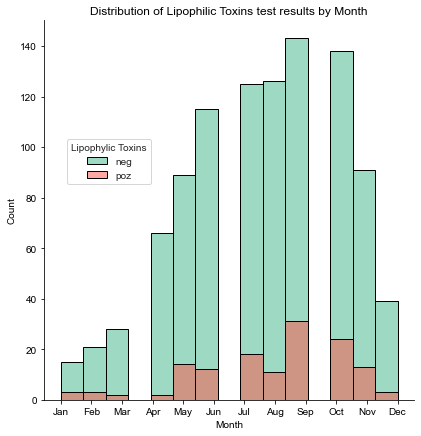

In [15]:
# Visualise target variable distribution by month
# Create a displot with hue
custom_palette = {'neg': '#3eb489', 'poz': '#ff5349'}

sns.displot(data=data, x="month", hue="lipophylic_toxins", kde=False, height=6, palette=custom_palette, legend=False)

# Customize the x-axis ticks and labels
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Customize the plot if desired
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.title('Distribution of Lipophilic Toxins test results by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title="Lipophylic Toxins", loc='upper left', labels=['neg', 'poz'], bbox_to_anchor=(0.05, 0.7))


# Show the plot
plt.savefig(f"{dir_path}/target_distribution_month-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

# Data preprocessing for modelling

## Removing instances with unlabeled target, label encoding

In [16]:
# Prepare for ML in scikit-learn
# labeled and unlabeled part
data_l = data[data['lipophylic_toxins'].notnull()]
data_ul = data[data['lipophylic_toxins'].isnull()]

# Remove missing values
data_l = data_l.dropna(how="any")
print(f"class distribution:")
print(data_l["lipophylic_toxins"].value_counts(dropna=False))

X = data_l.drop("lipophylic_toxins", axis=1)
y = data_l["lipophylic_toxins"]

# sklearn lable encoding
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(f"class encoding: ['neg','poz'] -> {le.transform(['neg','poz'])}")

class distribution:
neg    956
poz    132
Name: lipophylic_toxins, dtype: int64
class encoding: ['neg','poz'] -> [0 1]


## Dimensionality reduction

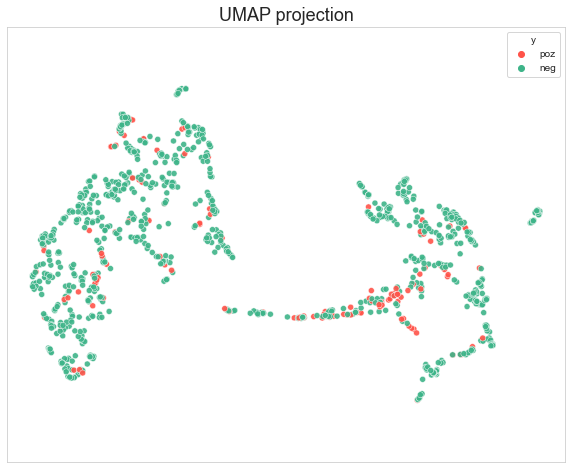

In [17]:
# Using UMAP for dimensionality reduction and visualisation before removing similar instances 
# Initialize UMAP

reducer = umap.UMAP(n_components=2, metric="correlation", random_state=rand_num)

# Fit and transform the data
embedding = reducer.fit_transform(X)

# Create a DataFrame for seaborn
df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df['y'] = pd.Series(y).map({0: 'neg', 1: 'poz'})

# Create a color palette dictionary with pastel colors
color_mapping = {'neg': '#3eb489', 'poz': '#ff5349'}

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='y', data=df, palette=color_mapping, alpha=0.9)

# Remove x and y axis names
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=18)
plt.savefig(f"{dir_path}/umap_before_removal-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()

## Clean instances close to the decision boundary

Clean the dataset by removing samples close to the decision boundary. Because the dataset is heavily imbalanced in favor of clas 0 (neg) we will remove instances from this class whenever finding samples which do not agree “enough” with their neighboorhood. The EditedNearestNeighbours will be used. One other option is to use Tomek links but it is more conservative and was found to perform slightly worse.

In [18]:
from collections import Counter
from imblearn.under_sampling import TomekLinks, RepeatedEditedNearestNeighbours

print(f'Original dataset shape: {Counter(y)}')
usmp = RepeatedEditedNearestNeighbours()
lastMajorityCount = Counter(y)[0]
X_res, y_res = usmp.fit_resample(X, y)
print(f'Resampled dataset shape {Counter(y_res)}')
X = X_res
y = y_res    

Original dataset shape: Counter({0: 956, 1: 132})
Resampled dataset shape Counter({0: 745, 1: 132})


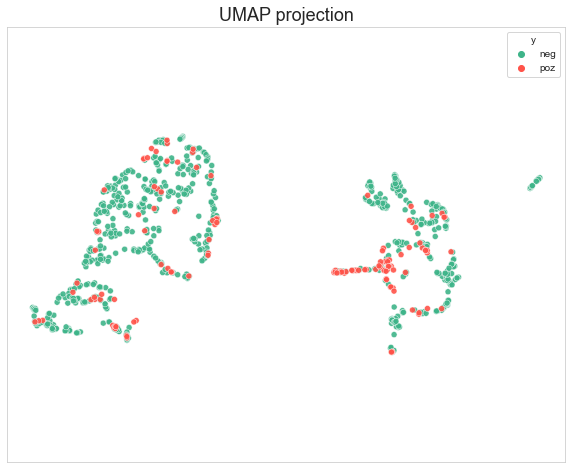

In [19]:
# Using UMAP for dimensionality reduction and visualisation after removing similar instances 
# Initialize UMAP

reducer = umap.UMAP(n_components=2, metric="correlation", random_state=rand_num)

# Fit and transform the data
embedding = reducer.fit_transform(X)

# Create a DataFrame for seaborn
df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df['y'] = pd.Series(y).map({0: 'neg', 1: 'poz'})

# Create a color palette dictionary with pastel colors
color_mapping = {'neg': '#3eb489', 'poz': '#ff5349'}

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='y', data=df, palette=color_mapping, alpha=0.9)

# Remove x and y axis names
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=18)
plt.savefig(f"{dir_path}/umap_after_removal-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')
plt.show()


# Descriptive statistics before split

In [20]:
X_stat = X.copy()
y_stat = y.copy()
y_stat = np.where(y == 0, 'neg', np.where(y == 1, 'poz', y))
X_stat["lipophylic_toxins"] = y_stat

# describe
description = X_stat.describe(include='all').round(0)
description = description.drop(['unique', 'top', 'freq'])

# Replace NaN values with "-" in the description
description = description.fillna("-")

# Convert numeric columns to integers
for col in description.select_dtypes(include=['float64']).columns:
    description[col] = description[col].astype(int)


# Calculate the number of missing values for each column
missing_values = data_l.isna().sum()
missing_values.name = 'missing_values'

# Append the missing_values row to the description DataFrame
description_with_missing = description.append(missing_values)
# description_with_missing = description_with_missing.drop(['unique', 'top', 'freq'])

# Transpose the DataFrame
transposed_description = description_with_missing.T
transposed_description

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


count  mean   std  min   25%   50%   75%    max  \
month                   877     8     3    1     6     8    10     12   
DSP                     877    93   285    0    10    40    80   5760   
Dinophysis caudata      877    21    87    0     0     0    10   1309   
Dinophysis fortii       877    23   119    0     0     0    10   2341   
Phalacroma rotundatum   877    15    31    0     0    10    20    393   
Dinophysis sacculus     877    26   174    0     0     0    10   4639   
Dinophysis tripos       877     2    11    0     0     0     0    110   
sun [h]                 877   162    60   30   116   165   212    278   
air temp                877    17     6   -1    13    18    22     27   
wind strength           877     3     0    1     3     3     3      5   
precipitation           877    59    54    0    18    45    82    266   
salinity                877    36     2   24    36    37    38     39   
T                       877    20     5    6    17    21    24     28   
Soca                    877  3340  2520  594  1610  2485  4170  16040   
lipophylic_toxins       877     -     -    -     -     -     -      -   

                      missing_values  
month                              0  
DSP                                0  
Dinophysis caudata                 0  
Dinophysis fortii                  0  
Phalacroma rotundatum              0  
Dinophysis sacculus                0  
Dinophysis tripos                  0  
sun [h]                            0  
air temp                           0  
wind strength                      0  
precipitation                      0  
salinity                           0  
T                                  0  
Soca                               0  
lipophylic_toxins                  0

In [21]:
X_stat["lipophylic_toxins"].value_counts()

neg    745
poz    132
Name: lipophylic_toxins, dtype: int64

## Train-test split

In [22]:
# All data
import copy

X_all = copy.copy(X)
y_all = copy.copy(y)

# train test split
X, X_eval, y, y_eval = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.30, random_state=rand_num) 

# Save X, X_eval, y, y_eval 
X.to_csv(f"{dir_path}/X_train.csv", index=False)
X_eval.to_csv(f"{dir_path}/X_test.csv", index=False)
pd.Series(y).to_csv(f"{dir_path}/y_train.csv", index=False)
pd.Series(y_eval).to_csv(f"{dir_path}/y_test.csv", index=False)

# # # Load 
# # X = pd.read_csv('X_train.csv')
# # X_eval = pd.read_csv('X_test.csv')
# y = pd.read_csv(f"{dir_path}/y_train.csv", squeeze=True).values
# y_eval = pd.read_csv(f"{dir_path}/y_test.csv", squeeze=True).values

# Correlation analysis on training data

In [23]:
# Calculate Pearson correlation between numeric features and binary target variable
pearson_correlations = X_all.corrwith(pd.Series(y_all), method='pearson')
pearson_correlations.name = 'Pearson'


# Combine the correlation values into a single dataframe
corr_df = pd.concat([pearson_correlations], axis=1)

# Create a new column for absolute Spearman correlation values
corr_df['Pearson_abs'] = corr_df['Pearson'].abs()

# Sort the dataframe by absolute Spearman correlation values
corr_df_sorted = corr_df.sort_values(by=['Pearson_abs'], ascending=False)

# Drop the absolute Spearman correlation column and return the sorted dataframe
corr_df_ranked = corr_df_sorted.drop(columns=['Pearson_abs']).round(2)

corr_df_ranked.to_csv(f"{dir_path}/Pearson_cor_coef-{notebook_name}-{timestamp}.csv", index=True)

corr_df_ranked

Pearson
Dinophysis tripos         0.24
salinity                 -0.21
Dinophysis fortii         0.19
DSP                       0.16
precipitation             0.13
Dinophysis caudata        0.10
sun [h]                  -0.08
wind strength            -0.07
Soca                      0.07
Dinophysis sacculus       0.07
month                     0.05
air temp                 -0.02
T                         0.02
Phalacroma rotundatum    -0.01

# Model Training and Evaluation

In [24]:
# Saving models

# Function to save best estimator
def save_best_estimator(grid_search_cv, classifier_name, notebook_name):
    # Get the best estimator from the GridSearchCV object
    best_estimator = grid_search_cv.best_estimator_

    # Construct the file name with the classifier name and notebook name
    pickle_file_name = f"{dir_path}/{classifier_name}-{notebook_name}-{timestamp}.pkl"
    
    # Save the best estimator to the file
    with open(pickle_file_name, 'wb') as f:
        pickle.dump(best_estimator, f)

    print(f"Best estimator saved as: {pickle_file_name}")

In [25]:
# Function for loading saved models

def load_best_estimator(pickle_file_name):
    with open(pickle_file_name, 'rb') as f:
        best_estimator = pickle.load(f)
    return best_estimator

## SVM

In [26]:
pd.set_option("display.max_rows", None)

pipeline = IMBLpipeline([
    ('smt', SMOTE(random_state=rand_num)), 
    ('under', RandomUnderSampler(random_state=rand_num)), 
    ('clf', SVC(random_state=rand_num))
])

parameters = {
            'clf__C': [0.1, 0.5, 1, 3, 10, 100],
            # 'clf__gamma': ['scale', 'auto'],
            # 'clf__kernel': ['linear', 'rbf', 'poly'],
            'clf__class_weight': ['balanced', None],
            'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
            'under__sampling_strategy': [0.5, 0.6, 0.7],
            'smt__k_neighbors': [1, 3, 5]
             }
nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc', 'recall_weighted']
gscv_svm = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
                    return_train_score=False, 
                    verbose=1, 
                    refit="f1",
                    n_jobs=-1)
resultsGSCV = gscv_svm.fit(X, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_svm, classifier_name, notebook_name)

# Save best parameters 
SVM_best_params = gscv_svm.best_params_
df = pd.DataFrame([SVM_best_params])
df.to_csv(f"{dir_path}/SVM_best_params-{notebook_name}-{timestamp}.csv", index=False)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best estimator saved as: models/05042024_1434/SVC-HAB_modelling_6_8-interp-HS_RF-05042024_1434.pkl


313  \
mean_fit_time                                                             0.04625   
std_fit_time                                                               0.0029   
mean_score_time                                                          0.032763   
std_score_time                                                           0.002032   
param_clf__C                                                                  100   
param_clf__class_weight                                                      None   
param_smt__k_neighbors                                                          3   
param_smt__sampling_strategy                                                  0.4   
param_under__sampling_strategy                                                0.6   
params                          {'clf__C': 100, 'clf__class_weight': None, 'sm...   
split0_test_recall                                                       0.222222   
split1_test_recall                                                       0.421053   
split2_test_recall                                                       0.210526   
split3_test_recall                                                       0.388889   
split4_test_recall                                                       0.444444   
mean_test_recall                                                         0.337427   
std_test_recall                                                          0.100469   
rank_test_recall                                                              171   
split0_test_precision                                                    0.666667   
split1_test_precision                                                    0.666667   
split2_test_precision                                                    0.444444   
split3_test_precision                                                    0.777778   
split4_test_precision                                                    0.727273   
mean_test_precision                                                      0.656566   
std_test_precision                                                       0.113922   
rank_test_precision                                                             4   
split0_test_f1                                                           0.333333   
split1_test_f1                                                           0.516129   
split2_test_f1                                                           0.285714   
split3_test_f1                                                           0.518519   
split4_test_f1                                                           0.551724   
mean_test_f1                                                             0.441084   
std_test_f1                                                              0.109196   
rank_test_f1                                                                    1   
split0_test_roc_auc                                                      0.771958   
split1_test_roc_auc                                                          0.75   
split2_test_roc_auc                                                      0.671559   
split3_test_roc_auc                                                      0.582799   
split4_test_roc_auc                                                      0.870192   
mean_test_roc_auc                                                        0.729302   
std_test_roc_auc                                                         0.096846   
rank_test_roc_auc                                                               8   
split0_test_recall_weighted                                              0.869919   
split1_test_recall_weighted                                              0.878049   
split2_test_recall_weighted                                              0.837398   
split3_test_recall_weighted                                              0.893443   
split4_test_recall_weighted                                              0.893443  

In [27]:
# Evaluation on test data
svm_clf = gscv_svm.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# svm_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation on test data
from sklearn.metrics import classification_report
y_pred = svm_clf.predict(X_eval)
SVM_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
SVM_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.90      0.95      0.93       224
         poz       0.61      0.42      0.50        40

    accuracy                           0.87       264
   macro avg       0.75      0.69      0.71       264
weighted avg       0.86      0.87      0.86       264



## Decision Tree Model (sklearn)

In [28]:
pd.set_option("display.max_rows", None)

pipeline = IMBLpipeline([
    ('smt', SMOTE(random_state=rand_num)), 
    ('under', RandomUnderSampler(random_state=rand_num)), 
    ('clf', DecisionTreeClassifier(random_state=rand_num))
])

parameters = {
            'clf__max_depth': [2,3,4],
            'clf__criterion': ['gini', 'entropy', 'log_loss'],
               'clf__class_weight': ['balanced', None],
               'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
               'under__sampling_strategy': [0.5, 0.6, 0.7],
               'smt__k_neighbors': [1, 3, 5]
             }
nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc', 'recall_weighted']
gscv_dt = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
                    return_train_score=False, 
                    verbose=1, 
                    refit="f1",
                    n_jobs=-1)
resultsGSCV = gscv_dt.fit(X, y)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_dt, classifier_name, notebook_name)

# Save best parameters 
DT_best_params = gscv_dt.best_params_
df = pd.DataFrame([DT_best_params])
df.to_csv(f"{dir_path}/DT_best_params-{notebook_name}-{timestamp}.csv", index=False)
# Save with pickle
with open(f"{dir_path}/DT_best_params-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(DT_best_params, f)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best estimator saved as: models/05042024_1434/DecisionTreeClassifier-HAB_modelling_6_8-interp-HS_RF-05042024_1434.pkl


391  \
mean_fit_time                                                            0.031914   
std_fit_time                                                             0.003258   
mean_score_time                                                          0.018476   
std_score_time                                                           0.001467   
param_clf__class_weight                                                      None   
param_clf__criterion                                                      entropy   
param_clf__max_depth                                                            4   
param_smt__k_neighbors                                                          3   
param_smt__sampling_strategy                                                  0.3   
param_under__sampling_strategy                                                0.6   
params                          {'clf__class_weight': None, 'clf__criterion': ...   
split0_test_recall                                                       0.555556   
split1_test_recall                                                       0.578947   
split2_test_recall                                                       0.473684   
split3_test_recall                                                       0.722222   
split4_test_recall                                                       0.666667   
mean_test_recall                                                         0.599415   
std_test_recall                                                          0.086897   
rank_test_recall                                                              105   
split0_test_precision                                                    0.333333   
split1_test_precision                                                         0.5   
split2_test_precision                                                    0.321429   
split3_test_precision                                                    0.448276   
split4_test_precision                                                    0.521739   
mean_test_precision                                                      0.424955   
std_test_precision                                                       0.083253   
rank_test_precision                                                            43   
split0_test_f1                                                           0.416667   
split1_test_f1                                                           0.536585   
split2_test_f1                                                           0.382979   
split3_test_f1                                                           0.553191   
split4_test_f1                                                           0.585366   
mean_test_f1                                                             0.494958   
std_test_f1                                                              0.079958   
rank_test_f1                                                                    1   
split0_test_roc_auc                                                      0.693122   
split1_test_roc_auc                                                      0.837551   
split2_test_roc_auc                                                      0.685729   
split3_test_roc_auc                                                      0.748397   
split4_test_roc_auc                                                      0.822917   
mean_test_roc_auc                                                        0.757543   
std_test_roc_auc                                                          0.06335   
rank_test_roc_auc                                                              11   
split0_test_recall_weighted                                              0.772358   
split1_test_recall_weighted                                              0.845528   
split2_test_recall_weighted                                              0.764228   
split3_test_recall_weighted                                              0.827869  

In [29]:
# Evaluation on test data
dt_clf = gscv_dt.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/12042023_1718/DecisionTreeClassifier-HAB_modelling_5_8-12042023_1718.pkl"
# dt_clf = load_best_estimator(pickle_file_name).steps[2][1]

y_pred = dt_clf.predict(X_eval)
DT_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
DT_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.90      0.87      0.89       224
         poz       0.40      0.47      0.43        40

    accuracy                           0.81       264
   macro avg       0.65      0.67      0.66       264
weighted avg       0.83      0.81      0.82       264



X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


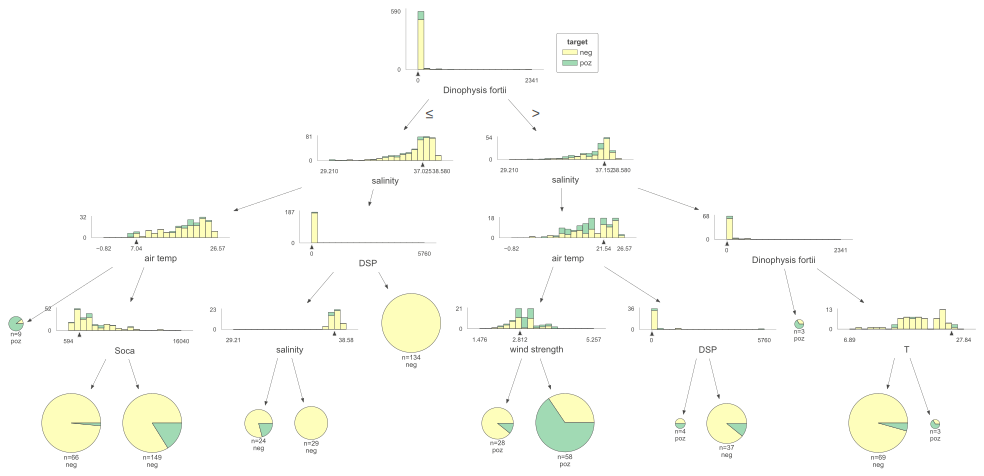

In [32]:
viz = dtreeviz.model(dt_clf, X, y,
                target_name="target",
                feature_names=X.columns,
                class_names=["neg", "poz"],
             # fancy=False,
               # scale=1.5
              )
viz.view()
# # Save the visualization as a PNG file
# viz_file_name = f"{dir_path}/DT_visualisation.svg"
# # viz.save(viz_file_name)
# print(f"Visualization saved as: {viz_file_name}")

# # Display the visualization
# viz

#### Retrain DT with best parameters from gridsearch on a all data

In [ ]:
# # Retrain DT with best parameters from gridsearch on a all data
# best_params = gscv_dt.best_params_

# # # Load the data with pickle
# # with open('DT_best_params.pkl', 'rb') as f:
# #     DT_best_params = pickle.load(f)

# print(best_params)

# # Create a pipeline with the best parameters
# best_pipeline = IMBLpipeline([
#     ('smt', SMOTE(sampling_strategy=best_params['smt__sampling_strategy'], k_neighbors=best_params['smt__k_neighbors'], random_state=rand_num)), 
#     ('under', RandomUnderSampler(sampling_strategy=best_params['under__sampling_strategy'], random_state=rand_num)), 
#     ('clf', DecisionTreeClassifier(max_depth=best_params['clf__max_depth'], criterion=best_params['clf__criterion'], class_weight=best_params['clf__class_weight'], random_state=rand_num))
# ])

# # Train the model on the entire dataset
# best_pipeline.fit(X_all, y_all)

# # Extract the decision tree classifier from the pipeline
# best_dt_clf = best_pipeline.named_steps['clf']

# # Save the best decision tree classifier with pickle
# with open(f"{dir_path}/best_DT_clf_all_data.pkl-{notebook_name}-{timestamp}.pkl", 'wb') as f:
#     pickle.dump(best_dt_clf, f)

# #Visualise DT
# from dtreeviz.trees import dtreeviz

# viz = dtreeviz(best_dt_clf, X_all, y_all,
#                 target_name="target",
#                 feature_names=X_all.columns,
#                 class_names=["neg", "poz"],
#                 # fancy=False,
#                 # scale=1.5
#               )

# # Save the visualization as a PNG file
# viz_file_name = f"{dir_path}/best_DT_visualisation_all-data.svg"
# viz.save(viz_file_name)
# print(f"Visualization saved as: {viz_file_name}")

# # Display the visualization
# viz

## Random Forest Model

#### Model evaluation (Random Forest)

In [83]:
# Random forest with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
   ('smt', SMOTE(random_state=rand_num)), 
   ('under', RandomUnderSampler(random_state=rand_num)), 
    ('clf', RandomForestClassifier(random_state=rand_num))
])

parameters = {
              'clf__n_estimators': [100,300,500],
              'clf__criterion': ['gini', 'entropy', 'log_loss'],
              'clf__class_weight': ['balanced', 'balanced_subsample', None],
              'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
              'under__sampling_strategy': [0.5, 0.6, 0.7],
              'smt__k_neighbors': [3, 5]
             }

nfolds = 5
scores = ['recall', 'precision', 'f1', 'roc_auc']
refit_score = 'f1'
gscv_rf = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
                    return_train_score=False, 
                    verbose=1, 
                    refit=refit_score,
                    n_jobs=-1)
resultsGSCV = gscv_rf.fit(X, y)

# Save the resultsGSCV with pickle
with open(f"{dir_path}/RF_resultsGSCV-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(resultsGSCV, f)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_rf, classifier_name, notebook_name)

# Save best parameters 
RF_best_params = gscv_rf.best_params_
df = pd.DataFrame([RF_best_params])
df.to_csv(f"{dir_path}/RF_best_params-{notebook_name}-{timestamp}.csv", index=False)
# Save with pickle
with open(f"{dir_path}/RF_best_params-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(RF_best_params, f)
    
results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())
pd.set_option("display.max_rows", None)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best estimator saved as: models/05042024_1434/RandomForestClassifier-HAB_modelling_6_8-interp-HS_RF-05042024_1434.pkl


348  \
mean_fit_time                                                            1.285944   
std_fit_time                                                             0.017644   
mean_score_time                                                           0.19221   
std_score_time                                                           0.001568   
param_clf__class_weight                                                      None   
param_clf__criterion                                                         gini   
param_clf__n_estimators                                                       300   
param_smt__k_neighbors                                                          3   
param_smt__sampling_strategy                                                  0.4   
param_under__sampling_strategy                                                0.5   
params                          {'clf__class_weight': None, 'clf__criterion': ...   
split0_test_recall                                                       0.555556   
split1_test_recall                                                       0.684211   
split2_test_recall                                                       0.473684   
split3_test_recall                                                            0.5   
split4_test_recall                                                       0.777778   
mean_test_recall                                                         0.598246   
std_test_recall                                                          0.115423   
rank_test_recall                                                              324   
split0_test_precision                                                       0.625   
split1_test_precision                                                    0.764706   
split2_test_precision                                                        0.75   
split3_test_precision                                                         1.0   
split4_test_precision                                                    0.823529   
mean_test_precision                                                      0.792647   
std_test_precision                                                       0.122192   
rank_test_precision                                                            18   
split0_test_f1                                                           0.588235   
split1_test_f1                                                           0.722222   
split2_test_f1                                                           0.580645   
split3_test_f1                                                           0.666667   
split4_test_f1                                                                0.8   
mean_test_f1                                                             0.671554   
std_test_f1                                                               0.08282   
rank_test_f1                                                                    1   
split0_test_roc_auc                                                      0.871164   
split1_test_roc_auc                                                       0.86665   
split2_test_roc_auc                                                      0.885628   
split3_test_roc_auc                                                      0.908654   
split4_test_roc_auc                                                      0.942575   
mean_test_roc_auc                                                        0.894934   
std_test_roc_auc                                                         0.027962   
rank_test_roc_auc                                                              21   

                                                                              366  \
mean_fit_time                                                            1.999183   
std_fit_time                                                             0.015773   
mean_score_time                                                          0.298835 

In [84]:
# Evaluation on test data
rf_clf = gscv_rf.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# rf_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation RF on test set
y_pred = rf_clf.predict(X_eval)
RF_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
RF_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.93      0.96      0.95       224
         poz       0.74      0.57      0.65        40

    accuracy                           0.91       264
   macro avg       0.83      0.77      0.80       264
weighted avg       0.90      0.91      0.90       264



Precision-Recall curve: Replicating the cross-validation in GridSearch process manually, using the best parameters found by GridSearchCV to train and evaluate the model on each fold and then plotting the precision-recall curves.

In [ ]:
# # ChatGPT: Plot the mean precision-recall curve. 

# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import precision_recall_curve, average_precision_score
# import matplotlib.pyplot as plt
# import numpy as np

# # Adjust these values to change the plot size
# plot_width = 10
# plot_height = 8

# cv = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num)

# mean_recall = np.linspace(0, 1, 100)
# precisions = []
# aucs = []

# # Create a larger plot
# plt.figure(figsize=(plot_width, plot_height))

# for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
#     best_estimator = resultsGSCV.best_estimator_
#     best_estimator.fit(X.iloc[train_idx], y[train_idx]) # Use iloc for X, direct indexing for y
#     probas_ = best_estimator.predict_proba(X.iloc[test_idx]) # Use iloc for X
    
#     # Compute Precision-Recall and plot curve
#     precision, recall, _ = precision_recall_curve(y[test_idx], probas_[:, 1]) # Direct indexing for y
#     precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
#     precisions[-1][0] = 1.0
#     aucs.append(average_precision_score(y[test_idx], probas_[:, 1]))
    
#     plt.plot(recall, precision, lw=1, alpha=0.3, 
#              label=f'Fold {i+1} AP = {aucs[-1]:0.2f}')

# mean_precision = np.mean(precisions, axis=0)
# mean_auc = np.mean(aucs)
# std_auc = np.std(aucs)

# # Plotting the mean precision-recall curve
# plt.plot(mean_recall, mean_precision, color='b',
#          label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#          lw=2, alpha=0.8)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# # plt.title('Precision-Recall Curve across CV Folds')
# # plt.legend(loc="best")
# plt.show()


Plot the mean ROC curve of the algorithm with best performing parameter selection. We will perform CV once again and plot the ROC curve for each fold and compute and plot the mean.

In [ ]:
# # Plot the ROC curve for RF
# from sklearn.metrics import RocCurveDisplay
# # # Load the data with pickle
# # with open('RF_resultsGSCV.pkl', 'rb') as f:
# #     resultsGSCV = pickle.load(f)
# clf = resultsGSCV.best_estimator_.steps[2][1]

# y_pred = clf.predict_proba(X_eval)[:, 1]
# RocCurveDisplay.from_predictions(y_eval, y_pred)
# plt.savefig(f"{dir_path}/RF_ROC_curve_noCV-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
# plt.show()

In [ ]:
# # Plot the ROC curve for RF

# # Run classifier with cross-validation and plot ROC curves
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rand_num)
# classifier = resultsGSCV.best_estimator_

# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

# fig, ax = plt.subplots(figsize=(10,8))
# for i, (train, test) in enumerate(cv.split(X_eval, y_eval)):
#     classifier.fit(X_eval.iloc[train], y_eval[train])
#     viz = RocCurveDisplay.from_estimator(
#         classifier,
#         X_eval.iloc[test],
#         y_eval[test],
#         name="fold {}".format(i),
#         alpha=0.3,
#         lw=1,
#         ax=ax,
#     )
#     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
#     interp_tpr[0] = 0.0
#     tprs.append(interp_tpr)
#     aucs.append(viz.roc_auc)

# ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Baseline (random prediction)", alpha=0.8)

# mean_tpr = np.mean(tprs, axis=0)
# mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
# std_auc = np.std(aucs)
# ax.plot(
#     mean_fpr,
#     mean_tpr,
#     color="b",
#     label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
#     lw=2,
#     alpha=0.8,
# )

# std_tpr = np.std(tprs, axis=0)
# tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
# tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# ax.fill_between(
#     mean_fpr,
#     tprs_lower,
#     tprs_upper,
#     color="grey",
#     alpha=0.2,
#     label=r"$\pm$ 1 std. dev.",
# )

# clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
# ax.set(
#     xlim=[-0.05, 1.05],
#     ylim=[-0.05, 1.05],
#     title=f'{clfname} evaluation (ROC-AUC, {nfolds}-fold CV)',
# )
# ax.legend(loc="lower right")
# plt.tight_layout()
# # plt.savefig(f"{dir_path}/RF_ROC_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
# plt.show()

Plot the mean precision-recall curve. The approach is the same as for the mean ROC curve.

In [ ]:
# # Plot the mean precision-recall curve. 
# from sklearn.metrics import PrecisionRecallDisplay
# # # Load the data with pickle
# # with open('RF_resultsGSCV.pkl', 'rb') as f:
# #     resultsGSCV = pickle.load(f)
# clf = resultsGSCV.best_estimator_.steps[2][1]

# y_pred = clf.predict_proba(X_eval)[:, 1]
# PrecisionRecallDisplay.from_predictions(y_eval, y_pred)
# plt.savefig(f"{dir_path}/RF_precision-recall_curve_noCV-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
# plt.show()

In [ ]:
# # Plot the mean precision-recall curve. 

# from sklearn.metrics import PrecisionRecallDisplay

# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rand_num)
# classifier = resultsGSCV.best_estimator_

# prs = []
# aucs = []
# mean_r = np.linspace(0, 1, 100)

# fig, ax = plt.subplots(figsize=(10,8))
# for i, (train, test) in enumerate(cv.split(X_eval, y_eval)):
#     classifier.fit(X_eval.iloc[train], y_eval[train])
#     viz = PrecisionRecallDisplay.from_estimator(
#         classifier,
#         X_eval.iloc[test],
#         y_eval[test],
#         name="fold {}".format(i),
#         alpha=0.3,
#         lw=1,
#         ax=ax,
#     )
#     interp_pr = np.interp(mean_r, viz.recall[::-1], viz.precision[::-1])
#     prs.append(interp_pr)

# mean_p = np.mean(prs, axis=0)
# ax.plot(
#     mean_r,
#     mean_p,
#     color="b",
#     label=f"mean",
#     lw=2,
#     alpha=0.8,
# )
# ax.legend(loc="lower left")
# clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
# ax.set(
#     # xlim=[-0.05, 1.05],
#     # ylim=[-0.05, 1.05],
#     title=f'{clfname} evaluation (precision-recall, {nfolds}-fold CV)')
# plt.tight_layout()
# # plt.savefig(f"{dir_path}/RF_precision-recall_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
# plt.show()

## Hierarchical shrinkage Random Forest

In [92]:
feature_names = X.columns.tolist()
X_np = X.to_numpy()

In [94]:
# Random forest with grid search for parameters, testing on 5-fold CV with shuffling

from imodels import HSTreeClassifierCV

hsrf_clf = HSTreeClassifierCV(estimator_=rf_clf, max_leaf_nodes=4)
hsrf_clf.fit(X_np, y)


# pipeline = IMBLpipeline([
#    ('smt', SMOTE(random_state=rand_num)), 
#    ('under', RandomUnderSampler(random_state=rand_num)), 
#     ('clf', RandomForestClassifier(random_state=rand_num))
# ])

# parameters = {
#               'clf__n_estimators': [100,300,500],
#               'clf__criterion': ['gini', 'entropy', 'log_loss'],
#               'clf__class_weight': ['balanced', 'balanced_subsample', None],
#               'smt__sampling_strategy': [ 0.2, 0.3, 0.4],
#               'under__sampling_strategy': [0.5, 0.6, 0.7],
#               'smt__k_neighbors': [3, 5]
#              }

# nfolds = 5
# scores = ['recall', 'precision', 'f1', 'roc_auc']
# refit_score = 'f1'
# gscv_hsrf = GridSearchCV(pipeline, 
#                     parameters, 
#                     scoring=scores,
#                     cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
#                     return_train_score=False, 
#                     verbose=1, 
#                     refit=refit_score,
#                     n_jobs=-1)
# resultsGSCV = gscv_hsrf.fit(X, y)

# # Save the resultsGSCV with pickle
# with open(f"{dir_path}/RF_resultsGSCV-{notebook_name}-{timestamp}.pkl", 'wb') as f:
#     pickle.dump(resultsGSCV, f)

# # Get the classifier name from the pipeline
# classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# # save the best estimator
# save_best_estimator(gscv_hsrf, classifier_name, notebook_name)

# # Save best parameters 
# RF_best_params = gscv_hsrf.best_params_
# df = pd.DataFrame([RF_best_params])
# df.to_csv(f"{dir_path}/RF_best_params-{notebook_name}-{timestamp}.csv", index=False)
# # Save with pickle
# with open(f"{dir_path}/RF_best_params-{notebook_name}-{timestamp}.pkl", 'wb') as f:
#     pickle.dump(RF_best_params, f)
    
# results = pd.DataFrame(resultsGSCV.cv_results_)
# display(results.sort_values(by=[f'rank_test_f1']).transpose())
# pd.set_option("display.max_rows", None)

In [95]:
# Evaluation on test data

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# hsrf_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation RF on test set
y_pred = hsrf_clf.predict(X_eval)
HSRF_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
HSRF_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.93      0.99      0.96       224
         poz       0.92      0.55      0.69        40

    accuracy                           0.92       264
   macro avg       0.92      0.77      0.82       264
weighted avg       0.92      0.92      0.92       264



X has feature names, but RandomForestClassifier was fitted without feature names


#### Feature importance (Random Forest)

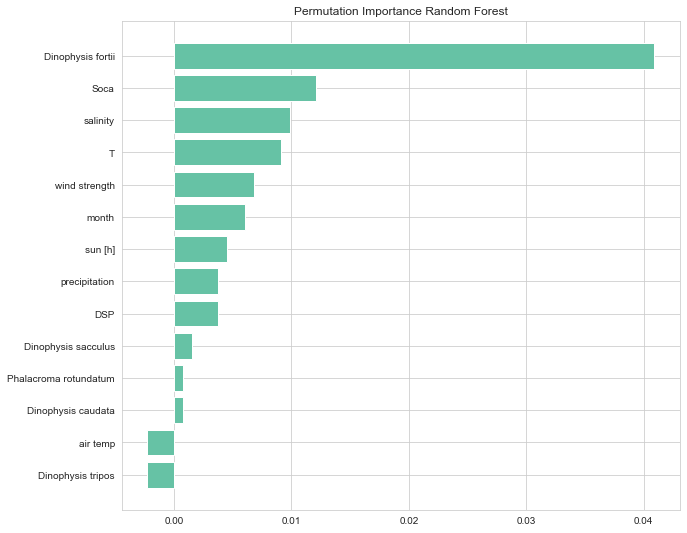

In [85]:
# Feature importance of model (best RandomForest from gridsearch) with three methods!

fig, (ax2) = plt.subplots(1, 1, figsize=(10,9))
plt.subplots_adjust(wspace=1.1)

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(rf_clf, X_eval, y_eval, random_state=rand_num)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X_eval.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance Random Forest")
plt.savefig(f"{dir_path}/permutation_importance_RF-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')

### SHAP

In [36]:
# # Get feature importance with SHAP
# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X)
# RF_shap = shap.summary_plot(shap_values, X, plot_type="bar")

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


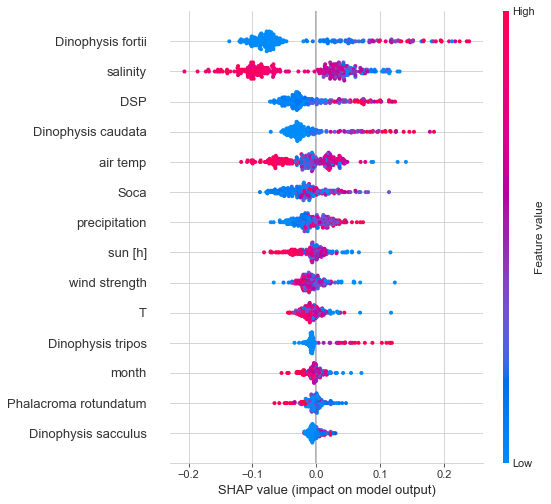

In [86]:
# # SHAP summary plot RF
# explainer = shap.TreeExplainer(rf_clf)
# shap_values = explainer.shap_values(X_eval)
# classid = 1

# # Save shap.summary_plot()
# fig = shap.summary_plot(shap_values[classid], X_eval, max_display=len(X_eval.columns), class_names=le.classes_, show=False)
# plt.savefig(f"{dir_path}/shap_summary_plot_RF-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

In [102]:
# SHAP summary plot RF
explainer = shap.TreeExplainer(hsrf_clf)
shap_values = explainer.shap_values(X_eval)
classid = 1

# Save shap.summary_plot()
fig = shap.summary_plot(shap_values[classid], X_eval, max_display=len(X_eval.columns), class_names=le.classes_, show=False)
plt.savefig(f"{dir_path}/shap_summary_plot_HSRF-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

InvalidModelError: Model type not yet supported by TreeExplainer: <class 'imodels.tree.hierarchical_shrinkage.HSTreeClassifierCV'>

In [ ]:
predict_fn = lambda x: hsrf_clf.predict_proba(x)[:,1]
X_eval_sample = shap.sample(X_eval, 50)
explainer = shap.KernelExplainer(predict_fn, X_eval_sample)
shap_values = explainer.shap_values(X_eval, nsamples="auto")

shap.summary_plot(shap_values, X_eval, feature_names=X_eval.columns.tolist())

In [ ]:
predict_fn = lambda x: hsrf_clf.predict_proba(x)[:, 1] 


  0%|          | 0/264 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
The default of 'normalize' will be set to False in versi

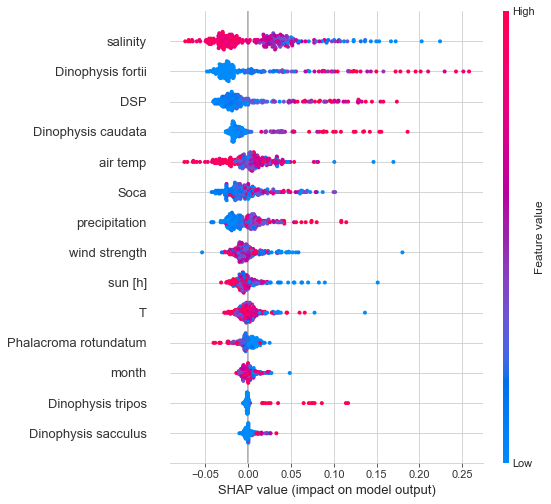

In [100]:
# SHAP summary plot HS RF
warnings.filterwarnings("ignore")
shap.initjs()

explainer = shap.KernelExplainer(hsrf_clf.predict_proba, shap.sample(X_eval, 50))
shap_values = explainer.shap_values(X_eval)
classid = 1

# Save shap.summary_plot()
fig = shap.summary_plot(shap_values[classid], X_eval, max_display=len(X_eval.columns), class_names=le.classes_, show=False)
plt.savefig(f"{dir_path}/shap_summary_plot_HSRF-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

In [ ]:
# # Try dependence contribution plot
# explainer = shap.TreeExplainer(rf_clf)
# shap_values = explainer.shap_values(X_eval)
# for i in X_eval.columns:
#     shap.dependence_plot(i, shap_values[1], X_eval) #interaction_index="salinity"

### Exaplain individual prediction with SHAP

In [69]:
# explain positive example prediction 
correct_indices = np.where((y_eval == 1) & (rf_clf.predict(X_eval) == y_eval))[0]

instanceID = correct_indices[12]
# instanceID = 120

instance = X_eval.iloc[[instanceID]]
display_instance = X_eval.iloc[[instanceID]]

prediction = rf_clf.predict(instance)[0]
prediction_probs = rf_clf.predict_proba(instance)[0]
print(f'real value: {y_eval[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(instance)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

real value: 1, 
predicted: 1, 
predicted probs: [0.41666667 0.58333333]
Explanation for prediction: class=1, p=0.5833333333333334


In [70]:
# explain negative example prediction 
correct_indices = np.where((y_eval == 0) & (rf_clf.predict(X_eval) == y_eval))[0]

instanceID = correct_indices[1]
# instanceID = 135

instance = X_eval.iloc[[instanceID]]
display_instance = X_eval.iloc[[instanceID]]

prediction = rf_clf.predict(instance)[0]
prediction_probs = rf_clf.predict_proba(instance)[0]
print(f'real value: {y_eval[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(instance)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

real value: 0, 
predicted: 0, 
predicted probs: [0.89333333 0.10666667]
Explanation for prediction: class=0, p=0.8933333333333333


### Neural Network Model

#### Model Evaluation (MLP)

In [41]:
# Preprocessing for NN in scikit_learn

# Model evaluation with the pipeline of SMOTE oversampling and undersampling on the training dataset only (within each cross-validation fold)!

#Remove months from X
Xnn = X.drop(X.columns[0], axis=1)

X_display = Xnn.copy()  # *used for SHAP visualization so we can show unscaled values

# scalling numeric values for NN
scaled_array = StandardScaler().fit_transform(Xnn)
Xsc = pd.DataFrame(scaled_array, columns=Xnn.columns)

In [42]:
# pd.set_option("display.max_rows", None)

In [43]:
# MLP with grid search for parameters, testing on 5-fold CV with shuffling

pipeline = IMBLpipeline([
    ('over', SMOTE(random_state=rand_num)),
    ('under', RandomUnderSampler(random_state=rand_num)),
    ('clf', MLPClassifier(solver='lbfgs', max_iter=5000, random_state=rand_num))
])

parameters = {'over__k_neighbors': range(1,7),
              'over__sampling_strategy': [0.5, 0.6, 0.8], # probaj poveča ovresampling do 0.9
              'under__sampling_strategy': [0.6, 0.7, 0.8],
              'clf__hidden_layer_sizes': [(2, ), (2, 2), (3,), (3,3)],
              'clf__solver': ['lbfgs', 'sgd', 'adam']
             }
nfolds = 5
scores = ['recall', "precision", 'f1', 'roc_auc']
gscv_NN = GridSearchCV(pipeline, 
                    parameters, 
                    scoring=scores,
                    cv=StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=rand_num),
                    n_jobs= -1, 
                    return_train_score=False, 
                    verbose=1, 
                    refit= "f1")
resultsGSCV = gscv_NN.fit(Xsc, y)

# Save the resultsGSCV with pickle
with open('MLP_resultsGSCV.pkl', 'wb') as f:
    pickle.dump(resultsGSCV, f)

# Get the classifier name from the pipeline
classifier_name = resultsGSCV.best_estimator_.named_steps['clf'].__class__.__name__
    
# save the best estimator
save_best_estimator(gscv_NN, classifier_name, notebook_name)

# Save best parameters 
MLP_best_params = gscv_NN.best_params_
df = pd.DataFrame([MLP_best_params])
df.to_csv(f"{dir_path}/MLP_best_params-{notebook_name}-{timestamp}.csv", index=False)
# Save with pickle
with open(f"{dir_path}/MLP_best_params-{notebook_name}-{timestamp}.pkl", 'wb') as f:
    pickle.dump(MLP_best_params, f)

results = pd.DataFrame(resultsGSCV.cv_results_)
display(results.sort_values(by=[f'rank_test_f1']).transpose())

Fitting 5 folds for each of 648 candidates, totalling 3240 fits



720 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/mmarzi/.pyenv/versions/3.8.0/envs/hab/lib/python3.8/site-packages/imblearn/pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/mmarzi/.pyenv/vers

Best estimator saved as: models/20052023_2320/MLPClassifier-HAB_modelling_6_8-20052023_2320.pkl


364  \
mean_fit_time                                                            0.464824   
std_fit_time                                                             0.296165   
mean_score_time                                                          0.011326   
std_score_time                                                           0.000402   
param_clf__hidden_layer_sizes                                                (3,)   
param_clf__solver                                                           lbfgs   
param_over__k_neighbors                                                         5   
param_over__sampling_strategy                                                 0.6   
param_under__sampling_strategy                                                0.7   
params                          {'clf__hidden_layer_sizes': (3,), 'clf__solver...   
split0_test_recall                                                       0.444444   
split1_test_recall                                                       0.736842   
split2_test_recall                                                       0.631579   
split3_test_recall                                                       0.388889   
split4_test_recall                                                       0.777778   
mean_test_recall                                                         0.595906   
std_test_recall                                                          0.154926   
rank_test_recall                                                               12   
split0_test_precision                                                        0.32   
split1_test_precision                                                    0.538462   
split2_test_precision                                                    0.272727   
split3_test_precision                                                    0.318182   
split4_test_precision                                                    0.482759   
mean_test_precision                                                      0.386426   
std_test_precision                                                       0.104299   
rank_test_precision                                                            44   
split0_test_f1                                                           0.372093   
split1_test_f1                                                           0.622222   
split2_test_f1                                                           0.380952   
split3_test_f1                                                               0.35   
split4_test_f1                                                           0.595745   
mean_test_f1                                                             0.464202   
std_test_f1                                                              0.118937   
rank_test_f1                                                                    1   
split0_test_roc_auc                                                      0.677778   
split1_test_roc_auc                                                      0.819838   
split2_test_roc_auc                                                      0.733047   
split3_test_roc_auc                                                      0.615385   
split4_test_roc_auc                                                      0.770299   
mean_test_roc_auc                                                        0.723269   
std_test_roc_auc                                                         0.071192   
rank_test_roc_auc                                                              40   

                                                                              522  \
mean_fit_time                                                            0.885051   
std_fit_time                                                             0.207467   
mean_score_time                                                          0.013731   
std_score_time                                                           0.002499 

In [44]:
# Evaluation on test data
nn_clf = gscv_NN.best_estimator_.steps[2][1]

# # Load the best estimator from the saved pickle file (replace with acctual file name)
# pickle_file_name = "models/timestamp/classifier_name-notebook_name.pkl"
# nn_clf = load_best_estimator(pickle_file_name).steps[2][1]

# Evaluation of NN on test set
X_eval_nn = X_eval.drop(X_eval.columns[0], axis=1)
X_eval_display = X_eval_nn.copy()

scaler = StandardScaler().fit(Xnn)
X_eval_sc = scaler.transform(X_eval_nn)
X_eval_sc = pd.DataFrame(X_eval_sc, columns=Xnn.columns)
y_pred = nn_clf.predict(X_eval_sc)
NN_classification_report = classification_report(y_eval, y_pred)

# Create classification report as dictionary
NN_report_dict = classification_report(y_eval, y_pred, output_dict=True)

print(classification_report(y_eval, y_pred, target_names=["neg", "poz"]))

              precision    recall  f1-score   support

         neg       0.91      0.79      0.84       224
         poz       0.32      0.55      0.40        40

    accuracy                           0.75       264
   macro avg       0.61      0.67      0.62       264
weighted avg       0.82      0.75      0.78       264



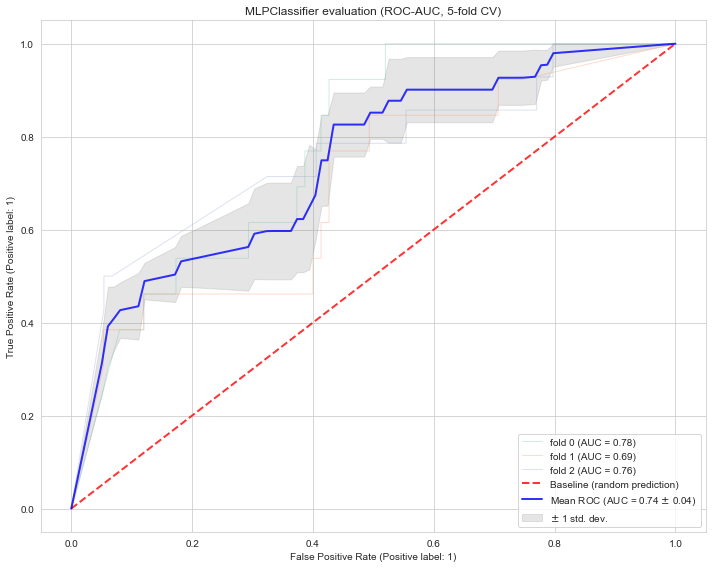

In [45]:
# Plot the ROC curve for MLP (Check code as moved form RF!). 

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3, shuffle=True)
classifier = resultsGSCV.best_estimator_

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval_sc, y_eval)):
    classifier.fit(X_eval_sc.iloc[train], y_eval[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_eval_sc.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Baseline (random prediction)", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (ROC-AUC, {nfolds}-fold CV)',
)
ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{dir_path}/MLP_ROC_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

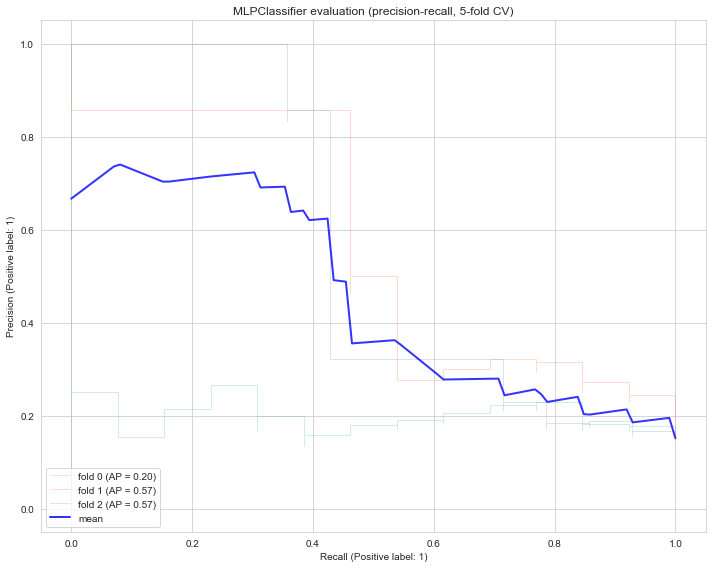

In [46]:
# Plot the mean precision-recall curve for MLP (Check code as moved form RF!). 

from sklearn.metrics import PrecisionRecallDisplay

cv = StratifiedKFold(n_splits=3, shuffle=True)
classifier = resultsGSCV.best_estimator_

prs = []
aucs = []
mean_r = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,8))
for i, (train, test) in enumerate(cv.split(X_eval_sc, y_eval)):
    classifier.fit(X_eval_sc.iloc[train], y_eval[train])
    viz = PrecisionRecallDisplay.from_estimator(
        classifier,
        X_eval_sc.iloc[test],
        y_eval[test],
        name="fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_pr = np.interp(mean_r, viz.recall[::-1], viz.precision[::-1])
    prs.append(interp_pr)

mean_p = np.mean(prs, axis=0)
ax.plot(
    mean_r,
    mean_p,
    color="b",
    label=f"mean",
    lw=2,
    alpha=0.8,
)
ax.legend(loc="lower left")
clfname = [str(step[1].__class__.__name__) for step in classifier.steps if step[0]=='clf'][0]
ax.set(
    # xlim=[-0.05, 1.05],
    # ylim=[-0.05, 1.05],
    title=f'{clfname} evaluation (precision-recall, {nfolds}-fold CV)')
plt.tight_layout()
plt.savefig(f"{dir_path}/MLP_precision-recall_curve-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300)
plt.show()

#### Feature Importance (MLP)

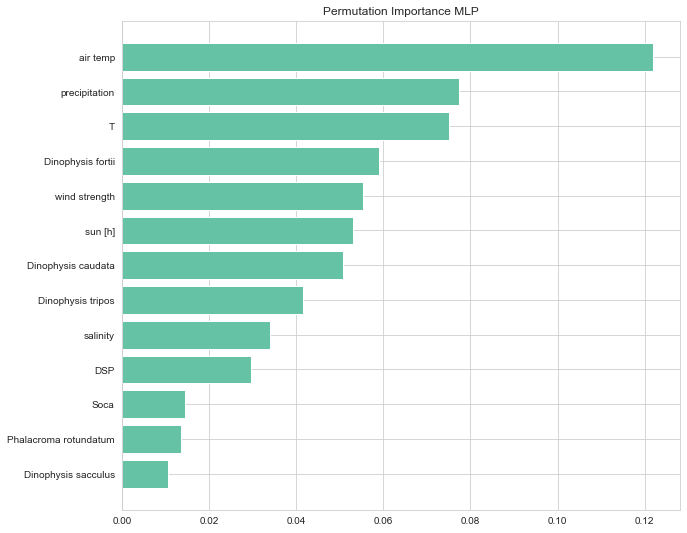

In [47]:
# Feature importance of model (best MLP from gridsearch) with three methods!

fig, (ax2) = plt.subplots(1, 1, figsize=(10,9))
plt.subplots_adjust(wspace=1.1)

# Get feature importance with Permutation Based Feature Importance (randomly shuffles each feature and compute the 
# change in the model’s performance. The features which impact the performance the most are the most important one).
perm_importance = permutation_importance(nn_clf, X_eval_sc, y_eval, random_state=rand_num)
perm_sorted_idx = perm_importance.importances_mean.argsort()
x2 = X_eval_sc.columns[perm_sorted_idx]
y2 = perm_importance.importances_mean[perm_sorted_idx]
ax2.barh(x2, y2)
ax2.set_title("Permutation Importance MLP")
plt.savefig(f"{dir_path}/permutation_importance_MLP-{notebook_name}-{timestamp}.pdf", format="pdf", dpi=300, bbox_inches='tight')

#### Feature importance with SHAP

First, visualize the impact of all features on both classes in one chart. We are using KernelExplainer but simpler general Explainer should be also tested once the SHAP code fixes all bugs.

**Note: SHAP explanations change between runs because of sampling and probably other random factors!**

In [48]:
# # explain the model's predictions using SHAP
# import shap
# import warnings
# warnings.filterwarnings("ignore")
# shap.initjs()

# explainer = shap.KernelExplainer(NN_model.predict_proba, shap.sample(X_eval_sc,20))
# shap_values = explainer.shap_values(X_eval_sc, nsamples=50)
# shap.summary_plot(shap_values, X_eval_sc, max_display=len(X.columns), class_names=le.classes_)

Now for each class separately. We observe the impact of features on the returned model's probability for a given class.

  0%|          | 0/264 [00:00<?, ?it/s]

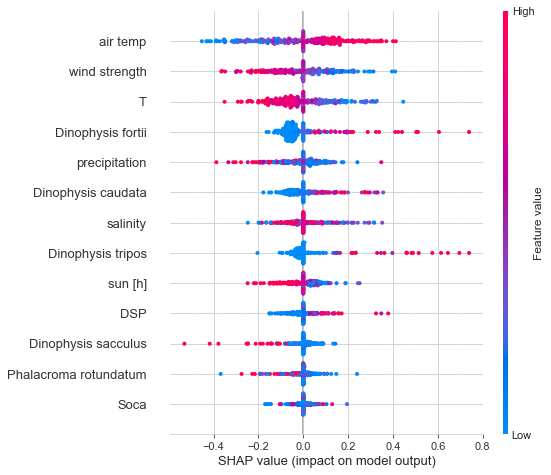

In [49]:
warnings.filterwarnings("ignore")
shap.initjs()

explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(X_eval_sc, 50))
shap_values = explainer.shap_values(X_eval_sc, nsamples=50)
classid = 1

# Save shap.summary_plot()
fig = shap.summary_plot(shap_values[classid], X_eval_display, max_display=len(X_eval_display.columns), class_names=le.classes_, show=False)
plt.savefig(f"{dir_path}/shap_summary_plot-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

  0%|          | 0/264 [00:00<?, ?it/s]

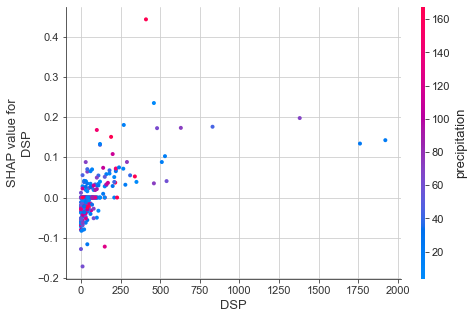

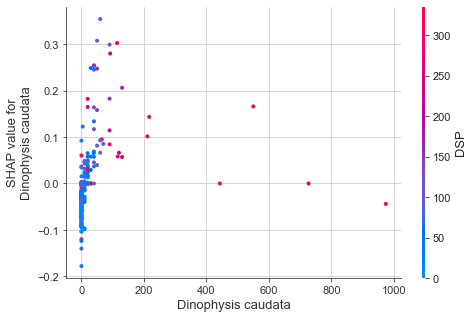

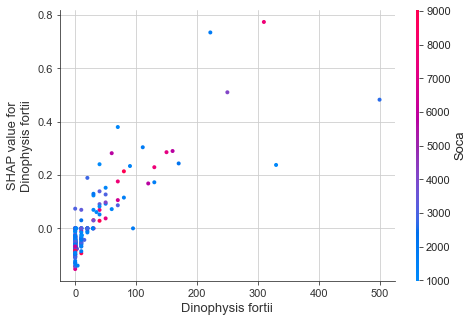

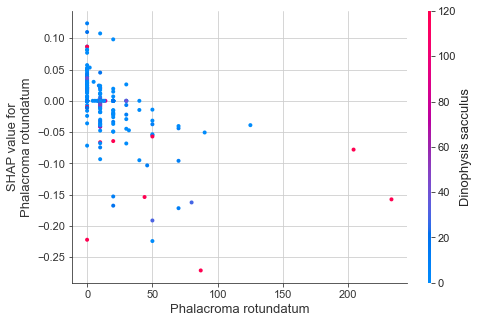

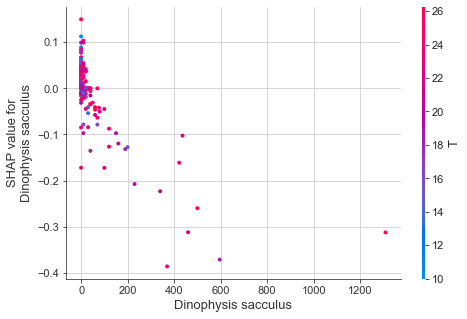

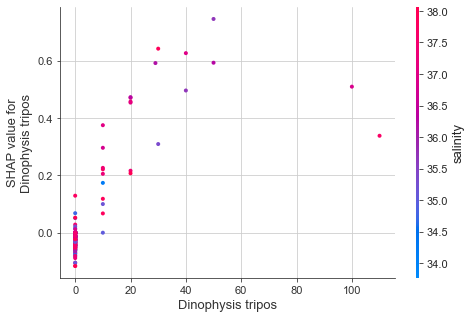

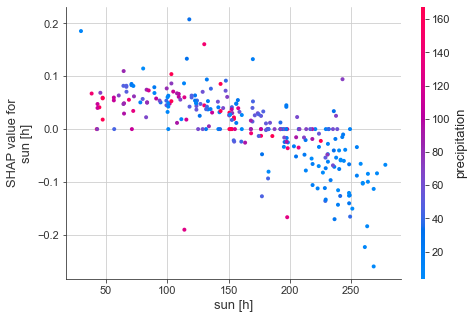

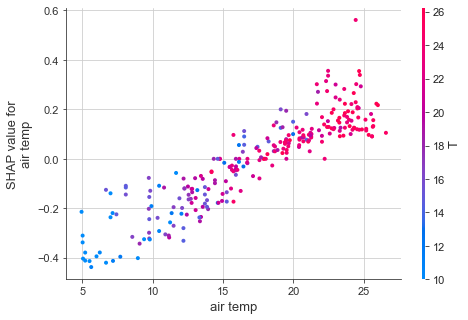

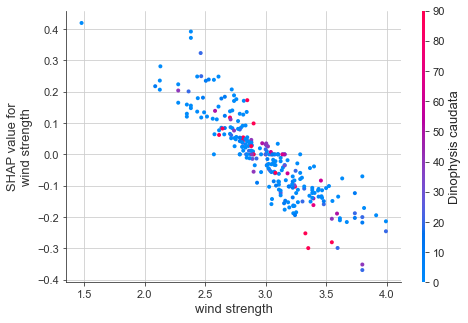

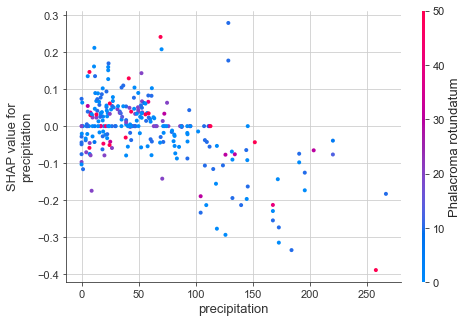

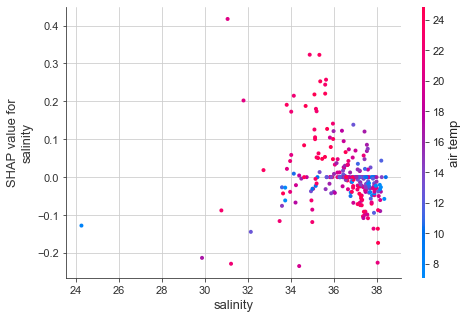

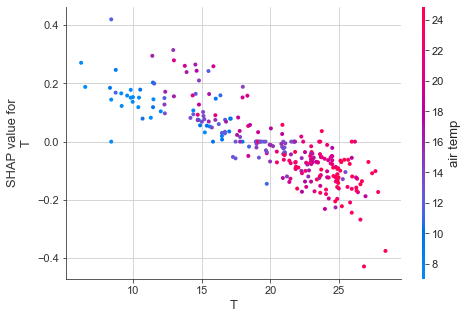

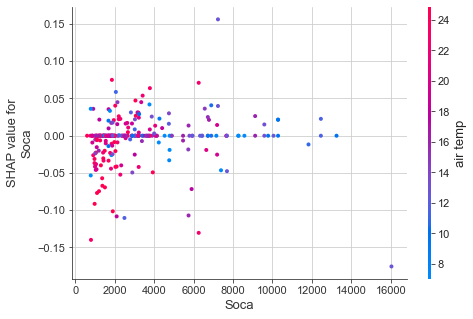

In [50]:
# Try dependence contribution plot
explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(X_eval_sc, 50))
shap_values = explainer.shap_values(X_eval_sc, nsamples=50)

for i in X_eval_display.columns:
    shap.dependence_plot(i, shap_values[1], X_eval_display,) #interaction_index="salinity"

Example intepretation: The fact this slopes upward says the higher the soca flow, the higher the model's prediction is for poz/neg. The spread suggests that other features must interact with Soca flow. 
In general, high Soca flow increases the chance of poz/neg. But if the sea temp is moderate or low, that trend reverses and even high soca flow does not increase preditions of poz/neg as the sea temp is too low.
https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values
---- 
To interpret the dependence contribution plot, look for trends or patterns in the relationship between the 'salinity' feature values and their SHAP values. For example:

If the points show a clear positive trend, it means that as the 'salinity' value increases, its positive contribution to the model's prediction also increases.
If the points show a clear negative trend, it means that as the 'salinity' value increases, its negative contribution to the model's prediction increases (i.e., higher 'salinity' values decrease the probability of class 1).
If there is no clear trend or the points are scattered randomly, it means that there is no strong relationship between the 'salinity' feature values and their SHAP values.
Additionally, observe the colors of the points in the plot. If there is a clear pattern in the colors, it may indicate that the interaction between 'salinity' and the interaction feature has a significant impact on the model's predictions. This can help you identify interactions between features that the model is capturing.

Now let's explain the prediction of a single instance. We will show the explanation of the bigger predicted probability to see why the model decided as it did. But in practice we could be interested only in the explanation of the probability of the positive prediction.

In [51]:
# explain positive example prediction 
correct_indices = np.where((y_eval == 1) & (nn_clf.predict(X_eval_sc) == y_eval))[0]

instanceID = correct_indices[0]
instance = X_eval_sc.iloc[[instanceID]]
display_instance = X_eval_display.iloc[[instanceID]]

prediction = nn_clf.predict(instance)[0]
prediction_probs = nn_clf.predict_proba(instance)[0]
print(f'real value: {y_eval[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(Xsc, 50))
shap_values = explainer.shap_values(instance, nsamples=500)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

real value: 1, 
predicted: 1, 
predicted probs: [0.2608704 0.7391296]
Explanation for prediction: class=1, p=0.7391296004766215


  0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
# explain negative example prediction 
correct_indices = np.where((y_eval == 0) & (nn_clf.predict(X_eval_sc) == y_eval))[0]

instanceID = correct_indices[0]
instance = X_eval_sc.iloc[[instanceID]]
display_instance = X_eval_display.iloc[[instanceID]]

prediction = nn_clf.predict(instance)[0]
prediction_probs = nn_clf.predict_proba(instance)[0]
print(f'real value: {y_eval[instanceID]}, \npredicted: {prediction}, \npredicted probs: {prediction_probs}')
max_p_id = prediction_probs.argmax()  # we will show the explanation of the bigger predicted probability
print(f'Explanation for prediction: class={max_p_id}, p={prediction_probs.max()}')

explainer = shap.KernelExplainer(nn_clf.predict_proba, shap.sample(Xsc, 50))
shap_values = explainer.shap_values(instance, nsamples=500)
shap.force_plot(explainer.expected_value[max_p_id], shap_values[max_p_id], features=display_instance)

real value: 0, 
predicted: 0, 
predicted probs: [1.00000000e+00 5.19196604e-69]
Explanation for prediction: class=0, p=1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Interpretation:

Observe the base value (Expected value) and the prediction line. This gives you an idea of the overall prediction for the instance compared to the average prediction.

Look at the colored arrows and identify the most important features, which are the ones with the longest arrows. These features have the greatest impact on the prediction.

Analyze the direction and color of the arrows to understand whether each feature increases or decreases the probability of the positive class (class 1) and whether the feature values are high or low.

Consider the interactions between the features and their combined impact on the prediction.

By analyzing the force plot, you can gain insights into the contributions of each feature to the model's prediction for a specific instance, helping you understand the model's decision-making process.

### LIME

In [53]:
import lime
from lime import lime_tabular

# Create a LIME explainer object
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(Xsc),
    feature_names=Xsc.columns,
    class_names=le.classes_,
    mode='classification'
)

# Exaplain an instance
instanceID = 100
lime_exp = lime_explainer.explain_instance(
    data_row=Xsc.iloc[instanceID], 
    predict_fn=nn_clf.predict_proba
)

lime_exp.show_in_notebook(show_table=True)

# Save the LIME explanation as an image file
# fig = lime_exp.as_pyplot_figure(label=1)
# plt.savefig(f"{dir_path}/lime_explanation-{classifier_name}-{notebook_name}-{timestamp}.pdf", format="pdf", bbox_inches='tight')

### Conclusion

In [54]:
# Define a function to extract the metrics from the classification report dictionary
def extract_metrics(report_dict):
    metrics = {}
    for class_label in report_dict:
        if class_label in ('accuracy', 'macro avg', 'weighted avg'):
            continue
        metrics[class_label] = {
            'precision': report_dict[class_label]['precision'],
            'recall': report_dict[class_label]['recall'],
            'f1-score': report_dict[class_label]['f1-score'],
            'support': report_dict[class_label]['support']
        }
    return metrics

# Extract the metrics for each classifier
SVM_metrics = extract_metrics(SVM_report_dict)
DT_metrics = extract_metrics(DT_report_dict)
RF_metrics = extract_metrics(RF_report_dict)
NN_metrics = extract_metrics(NN_report_dict)

# Create a dictionary to store the metrics for each classifier
classifier_metrics = {
    'Support Vector Machines': SVM_metrics,
    'Decision Tree': DT_metrics,
    'Random Forest': RF_metrics,
    'Neural Network': NN_metrics
}

# Convert the dictionary to a pandas DataFrame
summary_df = pd.concat({k: pd.DataFrame(v).transpose() for k, v in classifier_metrics.items()}, axis=0)
summary_df.reset_index(inplace=True)
summary_df.columns = ['Classifier', 'Class', 'Precision', 'Recall', 'F1-score', 'Support']

# Map the original class labels to the new names
class_name_mapping = {
    '0': 'neg',
    '1': 'poz'
}
summary_df['Class'] = summary_df['Class'].map(class_name_mapping)

# Filter the summary DataFrame to display only the 'poz' class
poz_summary_df = summary_df.query("Class == 'poz'")

# Display the filtered summary DataFrame
poz_summary_df

Classifier Class  Precision  Recall  F1-score  Support
1  Support Vector Machines   poz   0.607143   0.425  0.500000     40.0
3            Decision Tree   poz   0.395833   0.475  0.431818     40.0
5            Random Forest   poz   0.741935   0.575  0.647887     40.0
7           Neural Network   poz   0.318841   0.550  0.403670     40.0

In [55]:
# Format table

poz_summary_df = poz_summary_df.round(2)
# poz_summary_df = poz_summary_df.set_index('Classifier')
poz_summary_df = poz_summary_df.drop(['Support', "Class"], axis=1)
# poz_summary_df = poz_summary_df.style.highlight_max(subset=['Precision', 'Recall', 'F1-score'], color='green')
poz_summary_df.to_csv(f"{dir_path}/results_summary_df.csv")
poz_summary_df["Timestamp"] = timestamp
poz_summary_df

Classifier  Precision  Recall  F1-score      Timestamp
1  Support Vector Machines       0.61    0.42      0.50  20052023_2320
3            Decision Tree       0.40    0.48      0.43  20052023_2320
5            Random Forest       0.74    0.57      0.65  20052023_2320
7           Neural Network       0.32    0.55      0.40  20052023_2320

In [56]:
# # Add results to results to results df
# df_results = pd.read_pickle("data/results/df_results_3_0")
# df_results

In [57]:
# df_results = df_results.append(poz_summary_df)
# df_results.to_pickle("data/results/df_results_3_0")
# df_results